# GhettoJPEG

An iPython (SageMath) Notebook roughly outlining the lossy compression algorithm used by the original JPEG standard. The explanations here are kept brief; details are available [here (PDF, German only, sorry)](https://unimplemented.org/files/fourier.pdf).

In [9]:
from scipy.fftpack import dct
from scipy.fftpack import idct
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import os

# stolen from https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

# stolen from https://stackoverflow.com/questions/16873441/form-a-big-2d-array-from-multiple-smaller-2d-arrays/16873755#16873755
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

def genQ(compression_rate):
    # Berechnung der Quantisierunsmatrix
    number = 0
    count = 0
    Q = []
    diff = compression_rate
    for m in range(8):
        Q.append([])
        for n in range(8):
            Q[m].append(number + diff)
            number += diff
            count  += 1
            if(n == 7):
                number = number-diff*n
    return Q

# Quantisierung der Matrizen
def Quantisierung(matrix,Qmatrix):
    edge = len(Qmatrix)
    FQ = np.zeros((edge, edge))
    for m in range(edge):
        for n in range(edge):
                zahl = (matrix[m][n])/(Qmatrix[m][n])
                FQ[m][n] = zahl.round()
    return FQ

#Dequantisierung
def Dequantisierung(matrix,Qmatrix):
    edge = len(Qmatrix)
    F = np.zeros((edge, edge))
    for m in range(8):
        for n in range(8):
                F[m][n] = (matrix[m][n])*(Qmatrix[m][n])
    return F

# transformiert jeweils die 3 Layer anhand der Diskreten Kosinus-Transformation
def DCT2D(array):
    return dct(dct(array, axis = 0), axis = 1)

def IDCT2D(array):
    return idct(idct(array, axis = 0), axis = 1)

In [6]:
def ghettoJPEG(input_path, compression_rate):
    img = Image.open(input_path)
    imgConv = img.convert('YCbCr')
    imgYCC = np.ndarray((img.size[1], img.size[0], 3), 'u1', imgConv.tobytes())

    Y = np.zeros((512,512))
    Cb = np.zeros((512,512))
    Cr = np.zeros((512,512))

    # speichert das 3D-Array in die entsprechenden 2D-Arrays Y,Cb und Cr
    for m in range(512):
            for n in range(512):
                Y[m][n]=imgYCC[m][n][0]
                Cb[m][n]=imgYCC[m][n][1]
                Cr[m][n]=imgYCC[m][n][2]

    Y8 = blockshaped(Y, 8, 8)
    Cb8 = blockshaped(Cb, 8, 8)
    Cr8 = blockshaped(Cr, 8, 8)

    for block in range(len(Y8)):
        Y8[block] = DCT2D(Y8[block])
        Cb8[block] = DCT2D(Cb8[block])
        Cr8[block] = DCT2D(Cr8[block])

    Q = genQ(compression_rate)

    for block in range(len(Y8)):
        Y8[block] = Quantisierung(Y8[block], Q)
        Cb8[block] = Quantisierung(Cb8[block], Q)
        Cr8[block] = Quantisierung(Cr8[block], Q)

    for block in range(len(Y8)):
        Y8[block] = Dequantisierung(Y8[block], Q)
        Cb8[block] = Dequantisierung(Cb8[block], Q)
        Cr8[block] = Dequantisierung(Cr8[block], Q)

    for block in range(len(Y8)):
        Y8[block] = IDCT2D(Y8[block])
        Cb8[block] = IDCT2D(Cb8[block])
        Cr8[block] = IDCT2D(Cr8[block])

    ResY = unblockshaped(Y8, 512, 512)
    ResCb = unblockshaped(Cb8, 512, 512)
    ResCr = unblockshaped(Cr8, 512, 512)
    
    RF = np.array([[[0.0 for k in range(3)] for j in range(512)] for i in xrange(512)], dtype=np.uint8)
    for m in range(512):
        for n in range(512):
            RF[m][n][0] = int(ResY[m][n]/255)
            RF[m][n][1] = int(ResCb[m][n]/255)
            RF[m][n][2] = int(ResCr[m][n]/255)
    
    np.savez_compressed('/tmp/check_size', a=RF)
    sz = os.path.getsize('/tmp/check_size.npz')
    os.remove('/tmp/check_size.npz')
    print("compressed coefficients size: %d bytes (%d KiB)" %  (sz, (sz/1024)))
    
    return RF

In [18]:
#from IPython.display import display, Markdown, Latex
#from io import BytesIO

#from IPython.display import Image as DImage

#for res in [1, 100, 250, 1000, 5000]:
#    display(Markdown("# Kompressionsfaktor %d" % res))
#    Rimg = Image.fromarray(ghettoJPEG("Lisa.png", res), 'YCbCr')
#    imgConv = Rimg.convert('RGB')
#    bio = BytesIO()
#    imgConv.save(bio, format='png')
#    display(DImage(bio.getvalue(), format='png'))

# Different Compression Factors (3000/1500/500/1)

Compare the output image quality and the "compressed coefficient size". The first picture only has 21 KiB! The almost uncompressed image with compression_rate=1 is at 528KiB more than 25 times larger!

compressed coefficients size: 22190 bytes (21 KiB)


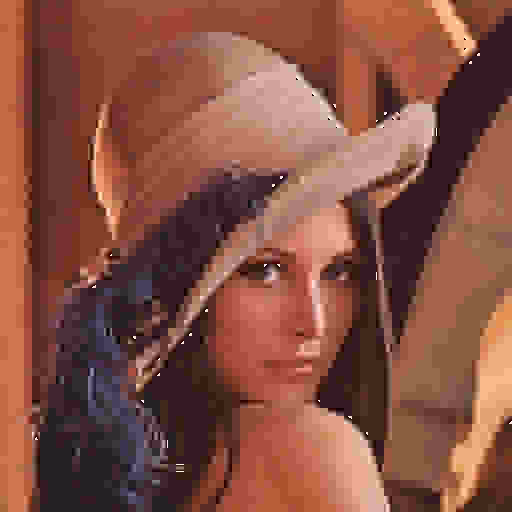

In [8]:
Rimg = Image.fromarray(ghettoJPEG("Lisa.png", 3000), 'YCbCr')
Rimg.convert('RGB')

compressed coefficients size: 57590 bytes (56 KiB)


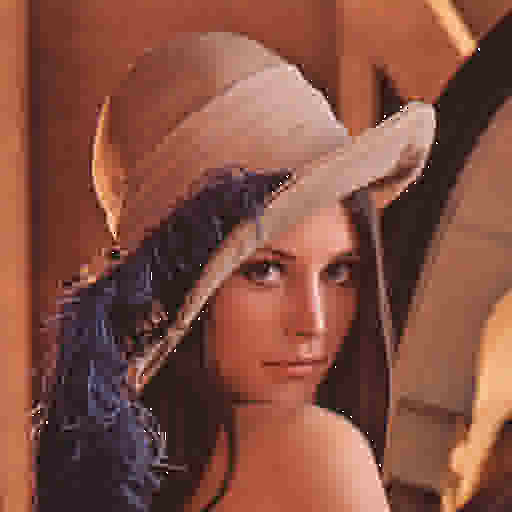

In [13]:
Rimg = Image.fromarray(ghettoJPEG("Lisa.png", 1500), 'YCbCr')
Rimg.convert('RGB')

compressed coefficients size: 189603 bytes (185 KiB)


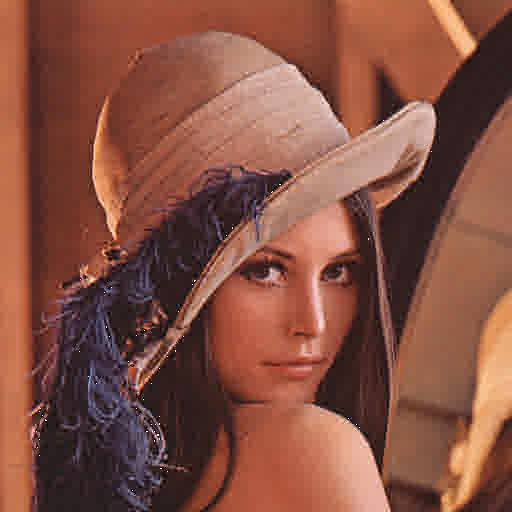

In [14]:
Rimg = Image.fromarray(ghettoJPEG("Lisa.png", 500), 'YCbCr')
Rimg.convert('RGB')

compressed coefficients size: 541561 bytes (528 KiB)


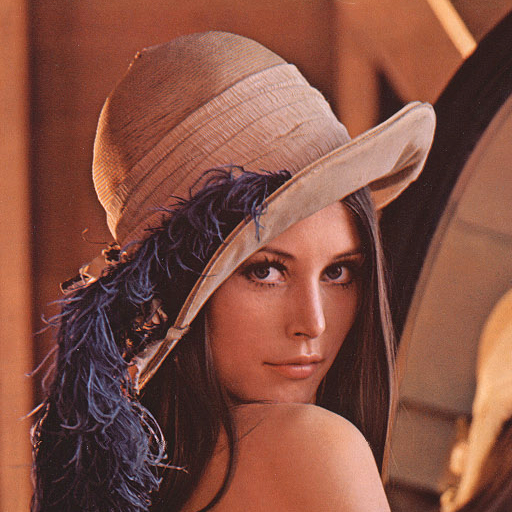

In [17]:
Rimg = Image.fromarray(ghettoJPEG("Lisa.png", 1), 'YCbCr')
Rimg.convert('RGB')